In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
store_sales=pd.read_csv("datasetLuxury (1).csv")
store_sales.tail(10)


,date,demand
55,2022-08,35
56,2022-09,33
57,2022-10,30
58,2022-11,26
59,2022-12,22
60,2023-01,27
61,2023-02,26
62,2023-03,30
63,2023-04,32
64,2023-05,31


In [ ]:
store_sales['date']=pd.to_datetime(store_sales['date'])


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    65 non-null     datetime64[ns]
 1   demand  65 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [ ]:
store_sales['date']=store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()


In [ ]:
monthly_sales['date']= monthly_sales['date'].dt.to_timestamp()

In [ ]:
#monthly_sales['date']+= pd.DateOffset(months=7)

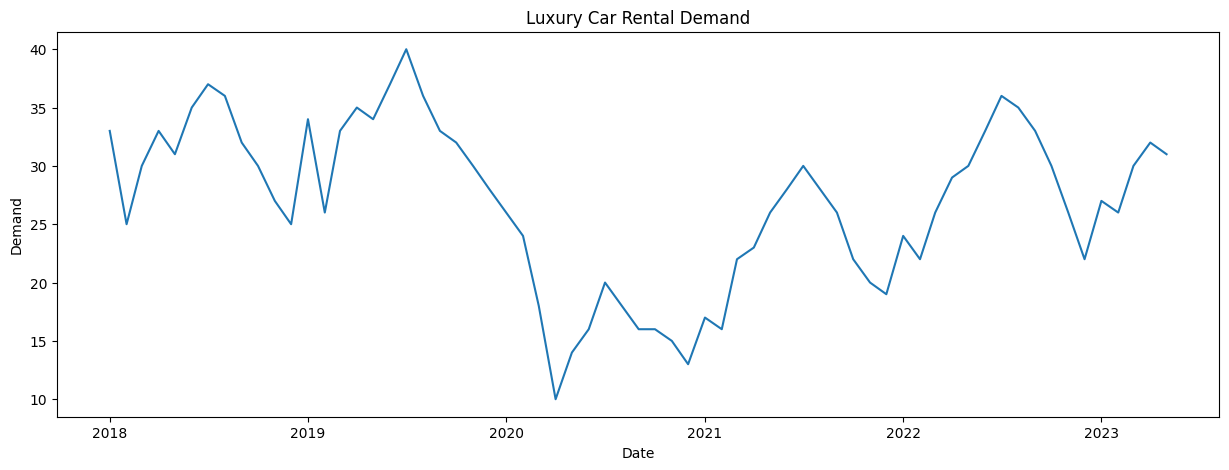

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['demand'])
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Luxury Car Rental Demand")
plt.show()

In [ ]:
monthly_sales['sales_diff']=monthly_sales['demand'].diff()
monthly_sales = monthly_sales.dropna()


In [ ]:
supervised_data = monthly_sales.drop(['date', 'demand'], axis=1)


In [ ]:
for i in range(1,13):
  col_name= 'month' + str(i)
  supervised_data[col_name]= supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(12)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,-8.0,9.0,-2.0,-3.0,-2.0,-4.0,-1.0,2.0,4.0,-2.0,3.0,5.0,-8.0
1,7.0,-8.0,9.0,-2.0,-3.0,-2.0,-4.0,-1.0,2.0,4.0,-2.0,3.0,5.0
2,2.0,7.0,-8.0,9.0,-2.0,-3.0,-2.0,-4.0,-1.0,2.0,4.0,-2.0,3.0
3,-1.0,2.0,7.0,-8.0,9.0,-2.0,-3.0,-2.0,-4.0,-1.0,2.0,4.0,-2.0
4,3.0,-1.0,2.0,7.0,-8.0,9.0,-2.0,-3.0,-2.0,-4.0,-1.0,2.0,4.0
5,3.0,3.0,-1.0,2.0,7.0,-8.0,9.0,-2.0,-3.0,-2.0,-4.0,-1.0,2.0
6,-4.0,3.0,3.0,-1.0,2.0,7.0,-8.0,9.0,-2.0,-3.0,-2.0,-4.0,-1.0
7,-3.0,-4.0,3.0,3.0,-1.0,2.0,7.0,-8.0,9.0,-2.0,-3.0,-2.0,-4.0
8,-1.0,-3.0,-4.0,3.0,3.0,-1.0,2.0,7.0,-8.0,9.0,-2.0,-3.0,-2.0
9,-2.0,-1.0,-3.0,-4.0,3.0,3.0,-1.0,2.0,7.0,-8.0,9.0,-2.0,-3.0


In [ ]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (40, 13)
Test Data Shape:  (12, 13)


In [ ]:
scaler= MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)


In [ ]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train shape: ", x_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", x_test.shape)
print("Y_train shape: ", y_train.shape)

X_train shape:  (40, 12)
Y_train shape:  (40,)
X_test shape:  (12, 12)
Y_train shape:  (40,)


In [ ]:

last_date = monthly_sales['date'].iloc[-2]
sales_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=10, freq='MS')
predict_df = pd.DataFrame({'date': sales_dates})
predict_df['date'] = pd.to_datetime(predict_df['date'])


In [ ]:
act_sale=monthly_sales['demand'][-13:].to_list()
print(act_sale)

[30, 33, 36, 35, 33, 30, 26, 22, 27, 26, 30, 32, 31]


In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [ ]:
lr_pre = lr_pre.reshape(-1,1)
#matrix - contains the input features of test data, and predicted output
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [ ]:
result_list=[]
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+ act_sale[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index =True, right_index = True)

In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['demand'][:10]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['demand'][:10])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['demand'][:10])
print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  6.618986737039297
Linear Regression MAE:  5.699778291401067
Linear Regression R2:  -1.2265913285955543


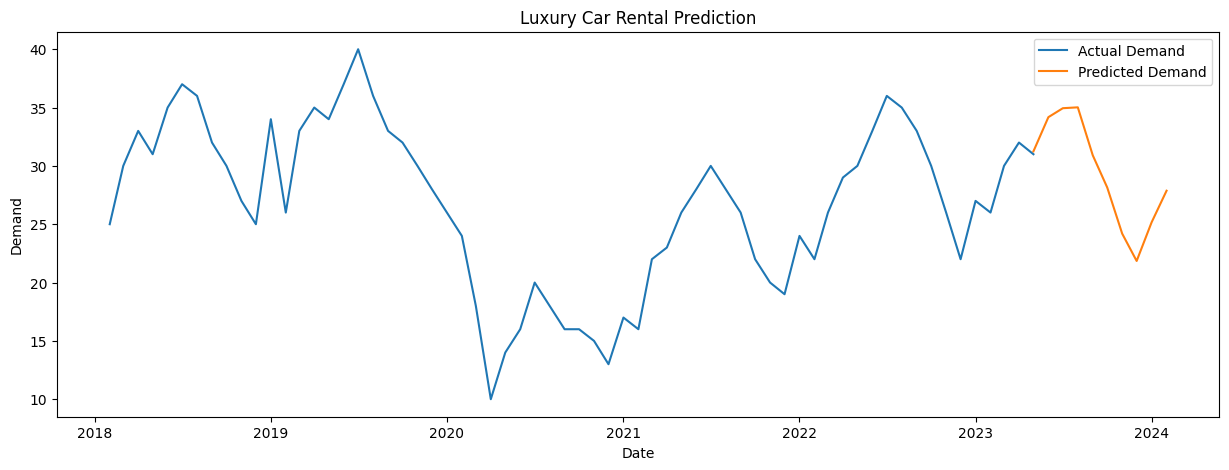

In [ ]:
#visualize
plt.figure(figsize=(15,5))
#actual demand
plt.plot(monthly_sales['date'], monthly_sales['demand'])
#predicted demand
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend(['Actual Demand','Predicted Demand'])
plt.title("Luxury Car Rental Prediction")
plt.show()

In [ ]:
predict_df.head(10)

,date,Linear Prediction
0,2023-05-01,31.246182
1,2023-06-01,34.176365
2,2023-07-01,34.944674
3,2023-08-01,35.018768
4,2023-09-01,30.908450
5,2023-10-01,28.145753
6,2023-11-01,24.193067
7,2023-12-01,21.850131
8,2024-01-01,25.162811
9,2024-02-01,27.872005


In [ ]:
monthly_sales.tail(12)

,date,demand,sales_diff
53,2022-06-01,33,3.0
54,2022-07-01,36,3.0
55,2022-08-01,35,-1.0
56,2022-09-01,33,-2.0
57,2022-10-01,30,-3.0
58,2022-11-01,26,-4.0
59,2022-12-01,22,-4.0
60,2023-01-01,27,5.0
61,2023-02-01,26,-1.0
62,2023-03-01,30,4.0
